In [1]:
import helper
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib import animation
import pickle
from tqdm import tqdm

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:163: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:184: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [2]:
def calc_conz_BH(all_fits, landmarks_list):
    #input: whole dataset with all experiments, repetitions, generations, fitnesses, individuals

    #setting up variables
    bestgen=np.array([landmarks_list[0],landmarks_list[1]])
    max_distance_best = helper.calculate_distance(bestgen[0], bestgen[1], landmarks_list[1], landmarks_list[2]) #bottom left corner
    max_distance_line = helper.calculate_distance(bestgen[0], bestgen[1], landmarks_list[3], landmarks_list[4]) #top right corner
    bot=np.array([0,0])
    top=np.array([1,1])
    diagonal_vector = top - bot
    diagonal_vector_expanded = diagonal_vector[np.newaxis, np.newaxis, np.newaxis, :, np.newaxis]
    bot_expanded = bot[np.newaxis, np.newaxis, np.newaxis, :, np.newaxis]

    #calculating generalism for each individual
    distance_best = np.sqrt((bestgen[0] - all_fits[:,:,:,0,:]) ** 2 + (bestgen[1] - all_fits[:,:,:,1,:]) ** 2) #want this to be small
    prop_distance_best = 1 - np.abs(distance_best)/np.abs(max_distance_best)

    distance_line = np.cross(diagonal_vector_expanded, all_fits - bot_expanded, axis = 3) / np.linalg.norm(diagonal_vector_expanded) #want this to be small
    prop_distance_line = 1 - np.abs(distance_line)/np.abs(max_distance_line)


    conz_BH = (prop_distance_best + prop_distance_line) / 2
    conz_BH_mean = np.mean(conz_BH, axis = 3)  #average across individuals  

    return conz_BH, conz_BH_mean

  0%|          | 0/1 [00:00<?, ?it/s]

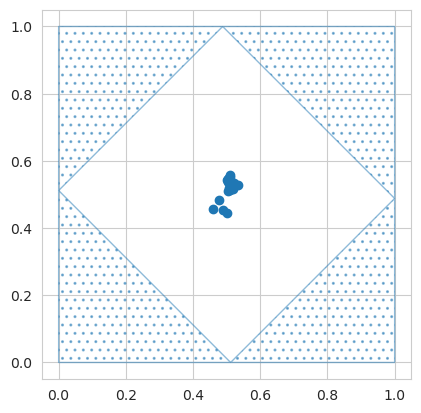

/tmp/ipykernel_11618/1700276425.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  landmarks_list = np.array([landmarks.iloc[2][0],landmarks.iloc[2][1], landmarks.iloc[5][0],landmarks.iloc[5][1], landmarks.iloc[0][0],landmarks.iloc[0][1] ])
100%|██████████| 1/1 [04:33<00:00, 273.74s/it]


In [5]:
rules = [30] #[150,102] #[22, 126, 154, 18, 122, 70,54,94,50,62,110,90,150,102] #30
for rule in tqdm(rules, position=0):

    pop_size = 20
    grn_size=22
    dev_steps = 22
    num_cells = 22
    geneid=1
    try_seedints = [69904,149796]

    all_targs=[]
    for s in try_seedints:
        random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
        #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
        start_pattern = helper.seedID2string(s, num_cells)
        start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
        targets = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        all_targs.append(targets)

    pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
    target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0], try_seedints[0])
    target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1], try_seedints[1])

    landmarks=helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

    root="~/scratch/detailed_save/"
    folders = ["variable","static","static"]
    seed_ints = ["69904-149796","69904","149796"]
    season_lens=[300,100_000,100_000]
    rules = [f"{rule}-{rule}", rule, rule]
    num_repeats = 15
    pop_size = 1000

    all_fits = []
    for g in range(len(season_lens)):
        fits=[np.loadtxt(os.path.expanduser(root+f"{folders[g]}/stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_both_fits.txt")) for i in range(num_repeats)]
        fits = np.array(fits)
        num_gens = int(fits.shape[1]/2/pop_size)
        fits = fits.reshape(num_repeats, num_gens, 2, pop_size)
        all_fits.append(fits)
    all_fits=np.vstack(all_fits)
    all_fits=np.reshape(all_fits, (3, num_repeats, num_gens, 2, pop_size ))
    all_fits.shape

    landmarks_list = np.array([landmarks.iloc[2][0],landmarks.iloc[2][1], landmarks.iloc[5][0],landmarks.iloc[5][1], landmarks.iloc[0][0],landmarks.iloc[0][1] ])
    conz_BH, conz_BH_mean = calc_conz_BH(all_fits, landmarks_list)

    pickle.dump(conz_BH_mean, open(f"generalism_{rule}.p", "wb" ) )


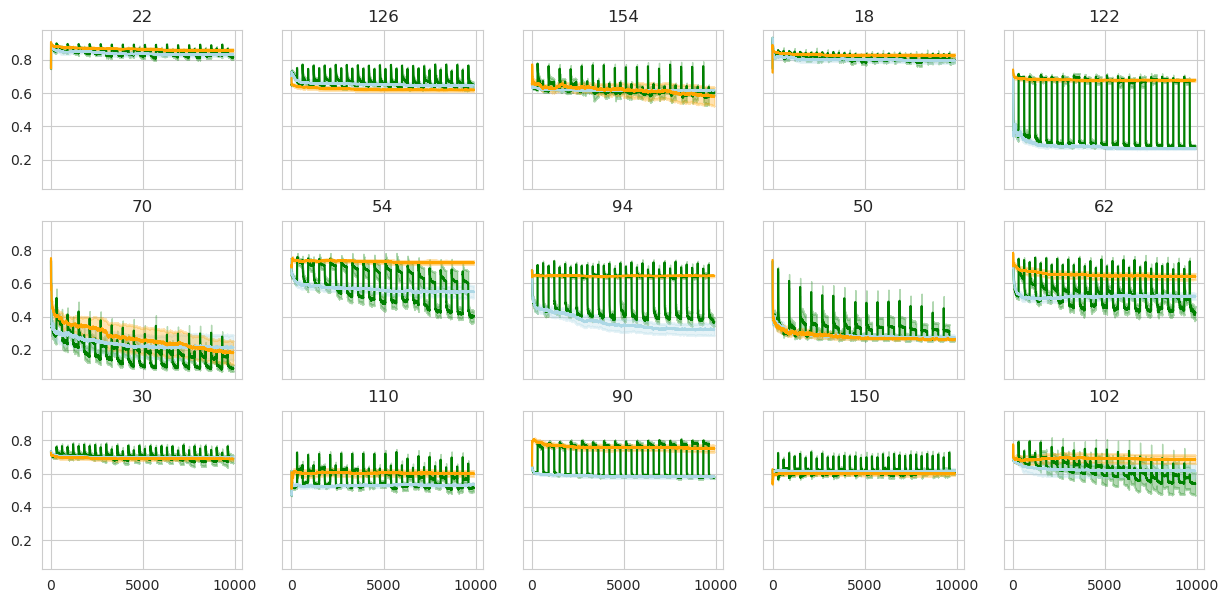

In [8]:
num_reps = 15
z_value = 1.96  # For a 95% confidence interval
labels=["vari","env1","env2"]
colors = ["green", "lightblue", "orange"]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),sharex=True, sharey=True)
axes = axes.flatten()

rules = [22, 126, 154, 18, 122, 70,54,94,50,62,30,110,90,150,102]

for idx, rule in enumerate(rules):

    conz_BH_mean = pickle.load(open(f"generalism_{rule}.p", "rb"))
    
    for i in range(3):
        mean1 = conz_BH_mean[i,:,:].mean(axis = 0)
        stderr1 = np.std(conz_BH_mean[i,:,:], axis=0) / np.sqrt(num_reps)
        ci_upper = mean1 + z_value * stderr1
        ci_lower = mean1 - z_value * stderr1
        axes[idx].fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3,color=colors[i])
        axes[idx].plot(mean1, "-", label= labels[i], color=colors[i])
        axes[idx].set_title(f"{rule}")
    #plt.legend()